In [1]:
# Imports
import json
import pprint
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Function definitions

def classifier_performance_metrics(classifier, X_test, y_test):
    y_test_pred = classifier.predict(X_test)
    matrix = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp )
    recall = tp / (tp + fn)
    print({
        "classifier": classifier,
        "tn": tn, 
        "fp": fp, 
        "fn": fn, 
        "tp": tp,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    })
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    }

def path_to_vector(path):
    # multi hot bag of bytes encoding
    path_bytes = [i for i in bytes(path, 'ascii')]
    vector = [0 for i in range(0x20, 0x7e+1)]
    for i in path_bytes:
        try:
            vector[i - 0x20] = 1
        except Exception as e:
            print(i)
            raise e
    return vector

def render_printable(i):
    i = i + 0x20
    if i > 32 and i < 127:
        r = chr(i)
    else: 
        r = hex(i)
    return r

def get_coefs(classifier, layer_index, neuron_index):
    return [i[neuron_index] for i in classifier.coefs_[layer_index]]

def render_coefs(coefs):
    coefs = [(render_printable(i), v) for i,v in enumerate(coefs)]
    coefs = sorted(coefs, key = lambda i: -i[1])
    return coefs

def coefs_heatmap(coefs):
    reshaped_keys = [[None for i in range(int((len(coefs)/16)+1))] for i in range(16)]
    reshaped_values = [[None for i in range(int((len(coefs)/16)+1))] for j in range(16)]
    for index in range(0, len(coefs)):
        row = index % 16
        col = index // 16
        reshaped_keys[row][col] = render_printable(index)
        reshaped_values[row][col] = coefs[index]
    reshaped_keys = pd.DataFrame(reshaped_keys)
    reshaped_values = pd.DataFrame(reshaped_values)
    colors = ["#ffffff", "#024f6e"]
    sns.set_theme()
    my_cmap = sns.blend_palette(colors, as_cmap = True)
    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(6, 13.5))
    return sns.heatmap(
        reshaped_values, 
        annot=reshaped_keys, 
        fmt='', 
        linewidths=.5, 
        ax=ax, 
        cmap=my_cmap,
        xticklabels=[hex(i) for i in range(0x20,0x7e+1,16)],
        yticklabels=[hex(i) for i in range(0,16)]
    ).get_figure()


In [7]:
# Load & partition data
X = []
y = []

with open('data/paths-benign.txt', 'r') as f:
    for path in f.readlines():
        path = path.strip()
        X.append(path)
        y.append(0)

with open('data/paths-malicious.txt', 'r') as f:
    for path in f.readlines():
        path = path.strip()
        X.append(path)
        y.append(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

1 	 ' 	 1.2652229150034104
2 	 ( 	 1.0984161345111552
3 	 ) 	 1.0573588816007604
4 	 0x20 	 1.0545668961701062
5 	 = 	 1.022829576638783


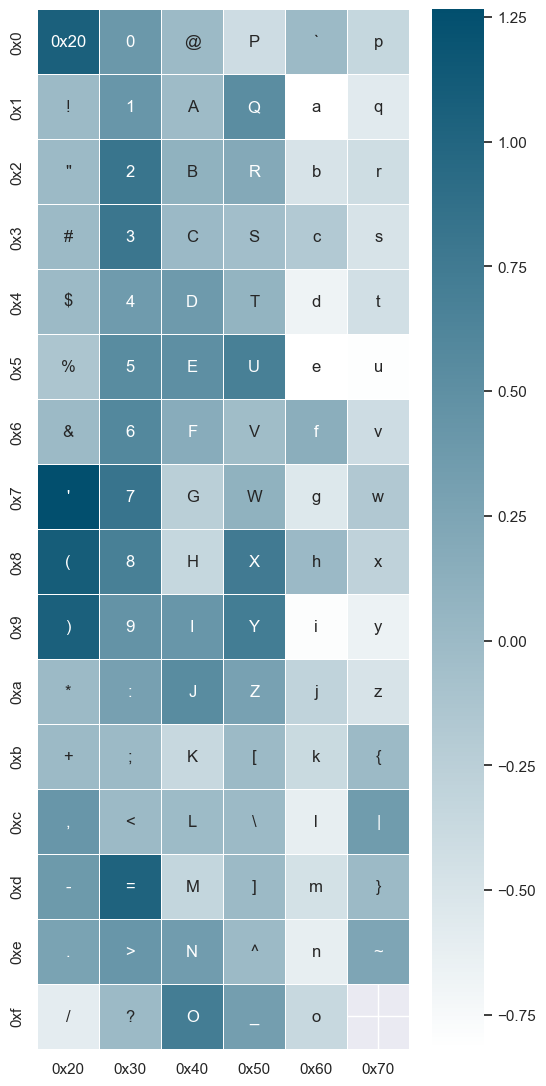

In [11]:
shallow_nn_classifier = MLPClassifier(hidden_layer_sizes=(), random_state=1234)
shallow_nn_classifier.fit([path_to_vector(x) for x in X_train], y_train)
coefs = get_coefs(shallow_nn_classifier,0,0)
for i, v in enumerate(render_coefs(coefs)[:5]):
    print(i+1, '\t', v[0], '\t', v[1])
fig = coefs_heatmap(coefs)
fig.savefig('classifier-coefficients.png')

In [ ]:


class SpaceClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if ' ' in i else 0 for i in X]

class ApostropheClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if "'" in i else 0 for i in X]

class EqualsClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if "=" in i else 0 for i in X]

class LeftParenthesisClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if "(" in i else 0 for i in X]

class RightParenthesisClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if ")" in i else 0 for i in X]

space_classifier = SpaceClassifier()
apostrophe_classifier = ApostropheClassifier()
equals_classifier = EqualsClassifier()
right_parenthesis_classifier = RightParenthesisClassifier()
left_parenthesis_classifier = LeftParenthesisClassifier()

shallow_nn_classifier_performance = classifier_performance_metrics(shallow_nn_classifier, [path_to_vector(x) for x in X_test], y_test)
space_classifier_performance = classifier_performance_metrics(space_classifier, X_test, y_test)
apostrophe_classifier_performance = classifier_performance_metrics(apostrophe_classifier, X_test, y_test)
equals_classifier_performance = classifier_performance_metrics(equals_classifier, X_test, y_test)
right_parenthesis_classifier_performance = classifier_performance_metrics(right_parenthesis_classifier, X_test, y_test)
left_parenthesis_classifier_performance = classifier_performance_metrics(left_parenthesis_classifier, X_test, y_test)

colors = ["#ffffff", "#024f6e"][::-1]
sns.set_theme(style='white')
palette = sns.blend_palette(colors, n_colors=4)

rows = []
for metric, value in shallow_nn_classifier_performance.items():
    rows.append(["Neural Network", metric, value])
for metric, value in space_classifier_performance.items():
    rows.append(["Rule: No Spaces", metric, value])
for metric, value in apostrophe_classifier_performance.items():
    rows.append(["Rule: No Apostrophes", metric, value])
for metric, value in equals_classifier_performance.items():
    rows.append(["Rule: No Equals", metric, value])
for metric, value in right_parenthesis_classifier_performance.items():
    rows.append(["Rule: No Right-Parens", metric, value])
for metric, value in left_parenthesis_classifier_performance.items():
    rows.append(["Rule: No Left-Parens", metric, value])
df = pd.DataFrame(rows, columns=["Classifier", "Metric", "Value"])
df.head()

ax = sns.barplot(
    x="Value", 
    y="Classifier",
    hue='Metric',
    data=df,
    palette=palette
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.get_figure().savefig('images/classifier-performance.png', dpi=1024, bbox_inches="tight")


In [ ]:
character_classes = []
for i in range(len(shallow_nn_classifier.coefs_[0])):
    coefficient = shallow_nn_classifier.coefs_[0][i][0]
    index = i + 0x20
    if index < ord('0'):
        character_classes.append(('Other', coefficient))
    elif index <= ord('9'):
        character_classes.append(('Digit', coefficient))
    elif index < ord('A'):
        character_classes.append(('Other', coefficient))
    elif index <= ord('Z'):
        character_classes.append(('Uppercase', coefficient))
    elif index < ord('a'):
        character_classes.append(('Other', coefficient))
    elif index <= ord('z'):
        character_classes.append(('Lowercase', coefficient))
    else:
        character_classes.append(('Other', coefficient))

df_character_classes = pd.DataFrame(character_classes, columns = ["Class", "Coefficient"])



colors = ["#ffffff", "#024f6e"][::-1]
sns.set_theme(style='white')
palette = sns.blend_palette(colors, n_colors=5)

fig = sns.swarmplot(
    data=df_character_classes, 
    x="Coefficient", 
    y="Class", 
    palette=palette
).get_figure()
fig.savefig('images/character-class-coefficients.png', dpi=1024, bbox_inches="tight")

In [ ]:
attack = "/query/-4441' UNION ALL SELECT CHAR(113,112,122,113,113)||(SELECT (CASE WHEN (RANDOMBLOB(-1)>0) THEN 1 ELSE 0 END))||CHAR(113,122,122,106,113)-- "
evasion = "abcdefghijklmnopqrstuvwxyz"
pprint.pprint(shallow_nn_classifier.predict([path_to_vector(attack)]))
pprint.pprint(shallow_nn_classifier.predict([path_to_vector(attack + evasion)]))


In [ ]:
deep_nn_classifier = MLPClassifier(hidden_layer_sizes=(2,), random_state=1234)
deep_nn_classifier.fit([path_to_vector(x) for x in X_train], y_train)
#deep_nn_coefficients_layer1 = [(render_printable(i), deep_nn_classifier.coefs_[0][i][0]) for i in range(len(deep_nn_classifier.coefs_[0]))]
#deep_nn_coefficients_layer2 = [(i, deep_nn_classifier.coefs_[1][i][0]) for i in range(len(deep_nn_classifier.coefs_[1]))]
#pprint.pprint(deep_nn_coefficients_layer1)
#pprint.pprint(deep_nn_coefficients_layer2)
print("Coefficients:")
pprint.pprint(deep_nn_classifier.coefs_)
print("intercepts:")
pprint.pprint(deep_nn_classifier.intercepts_)
pprint.pprint(len(deep_nn_classifier.coefs_))
pprint.pprint(len(deep_nn_classifier.coefs_[0]))
pprint.pprint(len(deep_nn_classifier.coefs_[1]))
pprint.pprint(deep_nn_classifier.predict([path_to_vector("/query/John")]))
pprint.pprint(deep_nn_classifier.predict([path_to_vector(attack)]))
pprint.pprint(deep_nn_classifier.predict([path_to_vector(attack + evasion)]))

print("input vector:")
pprint.pprint(numpy.array((path_to_vector(attack))).shape)
print("coefs[0]")
pprint.pprint(numpy.array(deep_nn_classifier.coefs_[0]).shape)
print("intercepts[0]")
pprint.pprint(numpy.array(deep_nn_classifier.intercepts_[0]).shape)
intermediate_outputs_0 = [max(0, i) for i in numpy.add(
    deep_nn_classifier.intercepts_[0],
    numpy.dot(
        path_to_vector(attack), 
        deep_nn_classifier.coefs_[0],
    )
)]
print("intermediate_outputs_0:")
pprint.pprint(numpy.array(intermediate_outputs_0).shape)
print("coefs[1]")
pprint.pprint(numpy.array(deep_nn_classifier.coefs_[1]).shape)
pprint.pprint(deep_nn_classifier.coefs_[1])
print("intercepts[1]")
pprint.pprint(numpy.array(deep_nn_classifier.intercepts_[1]).shape)
intermediate_outputs_1 = [max(0, i) for i in numpy.add(
    deep_nn_classifier.intercepts_[1],
    numpy.dot(
        intermediate_outputs_0,
        deep_nn_classifier.coefs_[1],
    )
)]
print("intermediate_outputs_1:")
pprint.pprint(numpy.array(intermediate_outputs_1).shape)
pprint.pprint(intermediate_outputs_1)
pprint.pprint(deep_nn_classifier.predict([path_to_vector(attack)]))


In [ ]:
## Node A: Counter-indicative (-1.453)
coefficients = [(render_printable(i), deep_nn_classifier.coefs_[0][i][0]) for i in range(len(deep_nn_classifier.coefs_[0]))]
reshaped_keys = [[None for i in range(int((len(coefficients)/16)+1))] for i in range(16)]
reshaped_values = [[None for i in range(int((len(coefficients)/16)+1))] for j in range(16)]
for index in range(0, len(coefficients)):
    character_code = index + 0x20
    i0 = index % 16
    i1 = index // 16
    print(index, character_code, i0, i1, coefficients[index][0], coefficients[index][1])
    reshaped_keys[i0][i1] = coefficients[index][0]
    reshaped_values[i0][i1] = coefficients[index][1]

reshaped_keys = pd.DataFrame(reshaped_keys)
print(reshaped_keys.shape)
reshaped_values = pd.DataFrame(reshaped_values)
print(reshaped_values.shape)


colors = ["#ffffff", "#024f6e"]
sns.set_theme()
my_cmap = sns.blend_palette(colors, as_cmap = True)
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(6, 13.5))
fig = sns.heatmap(
    reshaped_values, 
    annot=reshaped_keys, 
    fmt='', 
    linewidths=.5, 
    ax=ax, 
    cmap=my_cmap,
    xticklabels=[hex(i) for i in range(0x20,0x7e+1,16)],
    yticklabels=[hex(i) for i in range(0,16)]
).get_figure()
fig.savefig('images/deep-classifier-coefficients-NodeA.png')



In [ ]:
## Node B: Indicative (1.11)
coefficients = [(render_printable(i), deep_nn_classifier.coefs_[0][i][1]) for i in range(len(deep_nn_classifier.coefs_[0]))]
reshaped_keys = [[None for i in range(int((len(coefficients)/16)+1))] for i in range(16)]
reshaped_values = [[None for i in range(int((len(coefficients)/16)+1))] for j in range(16)]
for index in range(0, len(coefficients)):
    character_code = index + 0x20
    i0 = index % 16
    i1 = index // 16
    #print(index, character_code, i0, i1, coefficients[index][0], coefficients[index][1])
    reshaped_keys[i0][i1] = coefficients[index][0]
    reshaped_values[i0][i1] = coefficients[index][1]

reshaped_keys = pd.DataFrame(reshaped_keys)
#print(reshaped_keys.shape)
reshaped_values = pd.DataFrame(reshaped_values)
#print(reshaped_values.shape)

colors = ["#ffffff", "#024f6e"]
sns.set_theme()
my_cmap = sns.blend_palette(colors, as_cmap = True)
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(6, 13.5))
fig = sns.heatmap(
    reshaped_values, 
    annot=reshaped_keys, 
    fmt='', 
    linewidths=.5, 
    ax=ax, 
    cmap=my_cmap,
    xticklabels=[hex(i) for i in range(0x20,0x7e+1,16)],
    yticklabels=[hex(i) for i in range(0,16)]
).get_figure()
fig.savefig('images/deep-classifier-coefficients-NodeB.png')

sorted_coefficients = sorted(coefficients, key = lambda i: -i[1])
print("Top ten characters: ")
pprint.pprint(sorted_coefficients[:10])
